# Entity Resolution project @ Wavestone
## Entity Matching

> *Datasets information from [here](https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html)*

> **Tristan PERROT**


## Import libraries


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch

device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:2


In [3]:
while 'model' not in os.listdir():
    os.chdir('..')

In [4]:
MODEL_NAME = ''
DATA_NAME = 'walmart-amazon'
COMPUTER = 'gpu4.enst.fr:' + str(device)[-1:]
DATA_DIR = os.path.join('data', DATA_NAME)

## Pre-processing

In [5]:
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch.nn as nn
from sentence_transformers import CrossEncoder, InputExample, SentencesDataset
from sentence_transformers.cross_encoder.evaluation import \
    CEBinaryClassificationEvaluator
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader

from model.utils import load_data

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
table_a_serialized, table_b_serialized, X_train_ids, y_train, X_valid_ids, y_valid, X_test_ids, y_test = load_data(DATA_DIR,)

In [7]:
X1_train, X2_train = [table_a_serialized[i[0]] for i in X_train_ids], [table_b_serialized[i[1]] for i in X_train_ids]
X1_valid, X2_valid = [table_a_serialized[i[0]] for i in X_valid_ids], [table_b_serialized[i[1]] for i in X_valid_ids]
X1_test, X2_test = [table_a_serialized[i[0]] for i in X_test_ids], [table_b_serialized[i[1]] for i in X_test_ids]

In [8]:
# Display the first 5 samples of the training set
for i in range(5):
    print(f'Sample {i}:')
    print(f'Entity1: {X1_train[i]}')
    print(f'Entity2: {X2_train[i]}')
    print(f'Label: {y_train[i]}')
    print()

Sample 0:
Entity1: [COL] brand [VAL] LaCie [COL] groupname [VAL] Electronics - General [COL] title [VAL] LaCie Portable 8x DVD-RW Drive with LightScribe [COL] price [VAL] 57.6 [COL] shelfdescr [VAL] LightScribe labeling software USB bus-powered Includes USB cable [COL] shortdescr [VAL] With the LaCie Portable 8x DVD- RW Drive with LightScribe you can easily create your own music video and photo CDs or DVDs wherever you go. It can conveniently record to double layer DVD-R RW DVD R RW and CD-R RW and it s USB bus powered so you only need one cable to start burning CDs and DVDs. An easy-to-use interface allows you to piece together sophisticated full-featured DVD movies in a matter of minutes complete with menus thumbnails and backgrounds for a totally customized DVD. It is equipped with LightScribe an innovative technology that allows you to burn silkscreen-quality labels directly onto CDs and DVDs with a laser instead of a printer. [COL] longdescr [VAL] LaCie Portable 8x DVD-RW Drive wi

In [9]:
train_datasets = [InputExample(texts=[X1_train[i], X2_train[i]], label=y_train[i]) for i in range(len(X_train_ids))]
valid_datasets = [InputExample(texts=[X1_valid[i], X2_valid[i]], label=y_valid[i]) for i in range(len(X_valid_ids))]
test_datasets = [InputExample(texts=[X1_test[i], X2_test[i]], label=y_test[i]) for i in range(len(X_test_ids))]
train_loader = DataLoader(train_datasets, shuffle=True, batch_size=16, num_workers=0)
valid_loader = DataLoader(valid_datasets, shuffle=False, batch_size=16, num_workers=0)
test_examples = DataLoader(test_datasets, shuffle=False, batch_size=16, num_workers=0)

valid_evaluation_set = [(e1, e2) for e1, e2 in zip(X1_valid, X2_valid)]

In [10]:
EPOCHS = 3
LR = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 300
CLASSIFIER_DROPOUT = None
threshold = 0.5

loss_fct = BCEWithLogitsLoss()

def callback(score, epoch, steps):
    print(f'Epoch {epoch} - Score {score} - Steps {steps}')

In [11]:
final_table_exports = ""
results = {}

In [12]:
def show_results():
    global results
    roc_curve_fig, roc_curve_ax = plt.subplots(figsize=(10, 10))
    acc_threshold_fig, acc_threshold_ax = plt.subplots(figsize=(10, 10))
    prec_recall_threshold_fig, prec_recall_threshold_ax = plt.subplots(figsize=(10, 10))
    f1_threshold_fig, f1_threshold_ax = plt.subplots(figsize=(10, 10))

    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for i, (model_name, (logits, train_time)) in enumerate(results.items()):
        y_pred = logits > threshold
        y_true = y_test
        print(f'Model: {model_name}')
        print(classification_report(y_true, y_pred))
        print(f'AUC: {roc_auc_score(y_true, logits)}')
        print(f'Train time: {train_time}')
        print()
        fpr, tpr, _ = roc_curve(y_true, logits)
        roc_curve_ax.plot(fpr, tpr, label=model_name)

        # Confusion matrix
        plt.figure()
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        thresholds = np.linspace(0, 1, 100)
        accuracies = []
        precions = []
        recalls = []
        f1_scores = []
        for th in thresholds:
            y_pred = logits > th
            accuracies.append(np.mean(y_pred == y_true))
            precions.append(np.sum(y_pred * y_true) / np.sum(y_pred) if np.sum(y_pred) != 0 else 1)
            recalls.append(np.sum(y_pred * y_true) / np.sum(y_true))
            f1_scores.append(2 * precions[-1] * recalls[-1] / (precions[-1] + recalls[-1]) if precions[-1] + recalls[-1] != 0 else 0)
        acc_threshold_ax.plot(thresholds, accuracies, label=model_name)
        prec_recall_threshold_ax.plot(thresholds, precions, label=model_name + " precision", color=colors[i])
        prec_recall_threshold_ax.plot(thresholds, recalls, label=model_name + " recall", color=colors[i], linestyle='--')
        f1_threshold_ax.plot(thresholds, f1_scores, label=model_name)


    
    roc_curve_ax.plot([0, 1], [0, 1], 'k--')
    roc_curve_ax.set_xlabel('False Positive Rate')
    roc_curve_ax.set_ylabel('True Positive Rate')
    roc_curve_ax.set_title('ROC curve')
    roc_curve_ax.legend()

    acc_threshold_ax.set_xlabel('Threshold')
    acc_threshold_ax.set_ylabel('Accuracy')
    acc_threshold_ax.set_title('Accuracy vs Threshold')
    acc_threshold_ax.legend()

    prec_recall_threshold_ax.set_xlabel('Threshold')
    prec_recall_threshold_ax.set_ylabel('Precision/Recall')
    prec_recall_threshold_ax.set_title('Precision/Recall vs Threshold')
    prec_recall_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label='Threshold = 0.5')
    prec_recall_threshold_ax.legend()

    f1_threshold_ax.set_xlabel('Threshold')
    f1_threshold_ax.set_ylabel('F1 Score')
    f1_threshold_ax.set_title('F1 Score vs Threshold')
    f1_threshold_ax.axvline(x=threshold, color='k', linestyle='--', label='Threshold = 0.5')
    f1_threshold_ax.legend()

    plt.show()

### MS Marco MiniLM l-12

- Architecture: MiniLM-L-12
- Parameters: ~33 million
- Layers: 12 Transformer layers
- Hidden Size: 384
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/ms-marco-TinyBERT-L-2-v2)
- MS MARCO Passage Retrieval is a large dataset with real user queries from Bing search engine with annotated relevant text passages.

In [13]:
MODEL_NAME = 'cross-encoder/ms-marco-MiniLM-L-12-v2'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [14]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT, default_activation_function=nn.Sigmoid())

In [15]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0 - Score 0.9592266691010585 - Steps -1


Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1 - Score 0.9590475085461085 - Steps -1


Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 - Score 0.9631822757170596 - Steps -1


In [16]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

In [17]:
# Exemple of prediction
print(f'Prediction: {y_pred[0]}')
print(f'Label: {y_test[0]}')
print(f'Sample 1: {X1_test[0]}')
print(f'Sample 2: {X2_test[0]}')

Prediction: False
Label: 0
Sample 1: [COL] brand [VAL]  [COL] groupname [VAL] Computers [COL] title [VAL] FileMate Imagine Series M2810 USB Standard Mouse [COL] price [VAL] 8.98 [COL] shelfdescr [VAL] 800dpi optical sensor Navigate smoothly with precision control Color White Jet Black [COL] shortdescr [VAL] The FileMate Imagine Series M2810 Wired Optical Mouse is fashioned in an ideal shape and size. This mouse is designed to fit comfortably all day without fatigue [COL] longdescr [VAL] FileMate Imagine Series M2810 Wired Optical Mouse Connectivity USB 800dpi optical sensor Ideal shape and size Navigate smoothly with precision control Plug and play Color White Jet Black [COL] imageurl [VAL] http://i.walmartimages.com/i/p/11/13/00/12/30/1113001230819_300X300.jpg [COL] orig_shelfdescr [VAL] <li>800dpi optical sensor<li>Navigate smoothly with precision control<li>Color: White/Jet Black [COL] orig_shortdescr [VAL] The FileMate Imagine Series M2810 Wired Optical Mouse is fashioned in an ide

In [18]:
e1, e2 = X1_test[np.nonzero(y_test)[0][0]], X2_test[np.nonzero(y_test)[0][0]]
print('Entity 1:', e1)
print('Entity 2:', e2)
print(f'Label: {y_test[np.nonzero(y_test)[0][0]]}')
print(f'Prediction: {y_pred[np.nonzero(y_test)[0][0]]}')

Entity 1: [COL] brand [VAL] Dell [COL] groupname [VAL] Electronics - General [COL] title [VAL] Dell SWITCH by Design Studio Lids Big Giant Plaid 17R [COL] price [VAL] 39.0 [COL] shelfdescr [VAL] Custom made for your 2011 17  Inspiron R series laptops Slides on along the top of the laptop and clicks in Big Giant Plaid design [COL] shortdescr [VAL] Personalize your Dell laptop with the Dell SWITCH by Design Studio Lids. You can change-out your lid with the push of a button. The Dell SWITCH by Design Studio Lid is custom made for your Inspiron R series laptop. It slides on along the top of the laptop and clicks in giving it the same look and feel of a permanent laptop lid. [COL] longdescr [VAL] Dell SWITCH by Design Studio Lids Big Giant Plaid 17R Custom made for your 2011 17  Inspiron R series laptops Slides on along the top of the laptop and clicks in Provides the same look and feel of a permanent laptop lid Big Giant Plaid design [COL] imageurl [VAL] http://i.walmartimages.com/i/p/00/8

### STS RoBERTa-base

- Architecture: RoBERTa-base
- Parameters: ~125 million
- Layers: 12 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-roberta-base)
- Train to predict the similarity between two sentences

In [19]:
MODEL_NAME = 'cross-encoder/stsb-roberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [20]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0 - Score 0.960905859228438 - Steps -1


Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1 - Score 0.9828135154965167 - Steps -1


Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 - Score 0.9818887063252858 - Steps -1


In [22]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

### STS DistilRoBERTa-base

- Architecture: DistilRoBERTa-base
- Parameters: ~82 million
- Layers: 6 Transformer layers
- Hidden Size: 768
- Attention Heads: 12
- Link to the model: [here](https://huggingface.co/cross-encoder/stsb-distilroberta-base)
- Train to predict the similarity between two sentences

In [23]:
MODEL_NAME = 'cross-encoder/stsb-distilroberta-base'
OUTPUT_PATH = os.path.join('results', DATA_NAME, MODEL_NAME)
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [24]:
model = CrossEncoder(MODEL_NAME, num_labels=1, device=device, classifier_dropout=CLASSIFIER_DROPOUT)

/home/infres/tperrot-21/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
start_train_time = time.time()
model.fit(train_dataloader=train_loader,
            loss_fct=loss_fct,
            evaluator=CEBinaryClassificationEvaluator(valid_evaluation_set, labels=y_valid, show_progress_bar=True),
            epochs=EPOCHS,
            warmup_steps=WARMUP_STEPS,
            output_path=OUTPUT_PATH,
            callback=callback,
            optimizer_params={'lr': LR},
            weight_decay=WEIGHT_DECAY,
            show_progress_bar=True)
train_time = time.time() - start_train_time

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 0 - Score 0.9663597051623795 - Steps -1


Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 1 - Score 0.9764630034154089 - Steps -1


Iteration:   0%|          | 0/682 [00:00<?, ?it/s]

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

Epoch 2 - Score 0.9745996666108953 - Steps -1


In [26]:
threshold = 0.8

In [27]:
logits = model.predict([[e1, e2] for e1, e2 in zip(X1_test, X2_test)], apply_softmax=True)
y_pred = logits > threshold
results[MODEL_NAME] = (logits, train_time)

Model: cross-encoder/ms-marco-MiniLM-L-12-v2
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1429
           1       0.94      0.91      0.92       114

    accuracy                           0.99      1543
   macro avg       0.96      0.95      0.96      1543
weighted avg       0.99      0.99      0.99      1543

AUC: 0.9976612279474052
Train time: 285.3609268665314

Model: cross-encoder/stsb-roberta-base
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1429
           1       0.95      0.95      0.95       114

    accuracy                           0.99      1543
   macro avg       0.97      0.97      0.97      1543
weighted avg       0.99      0.99      0.99      1543

AUC: 0.9982812173891692
Train time: 772.6419219970703

Model: cross-encoder/stsb-distilroberta-base
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      142

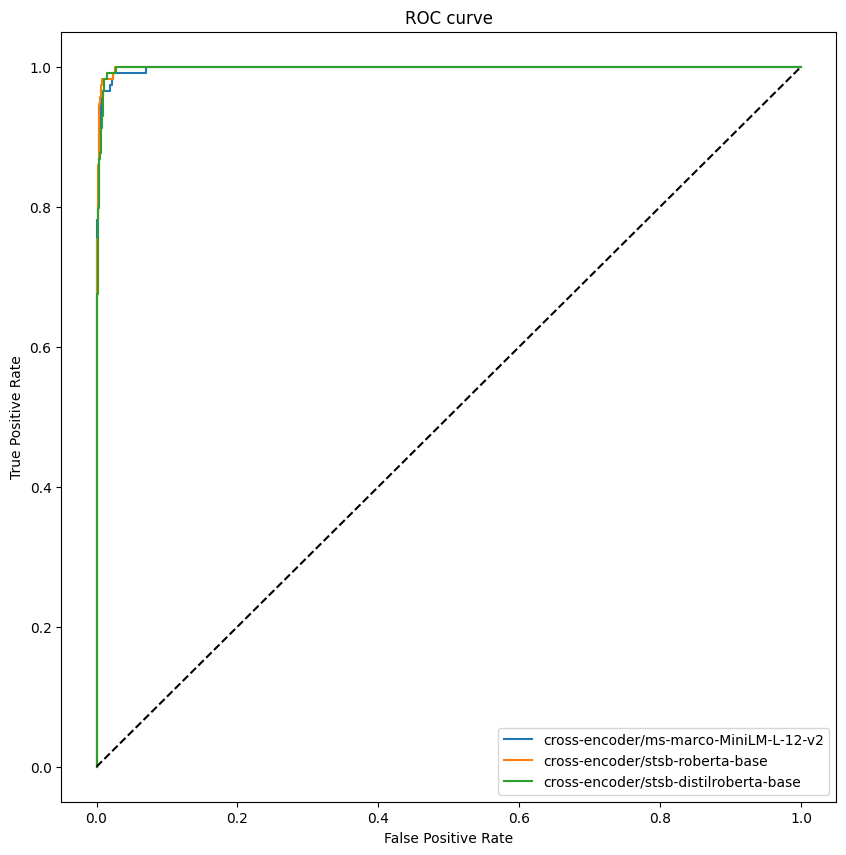

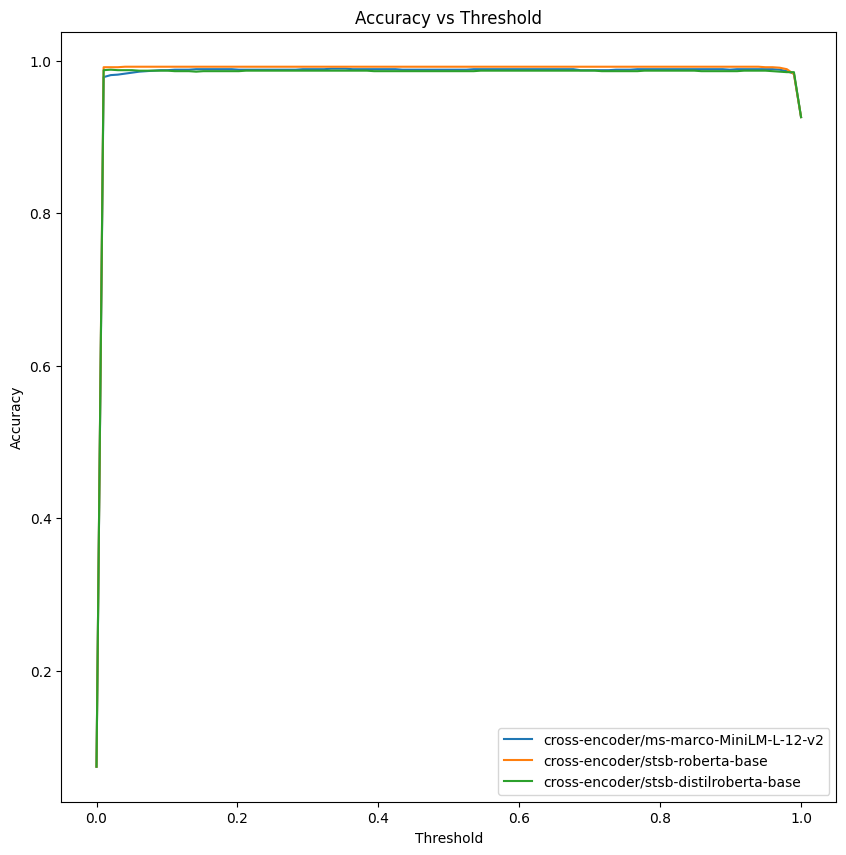

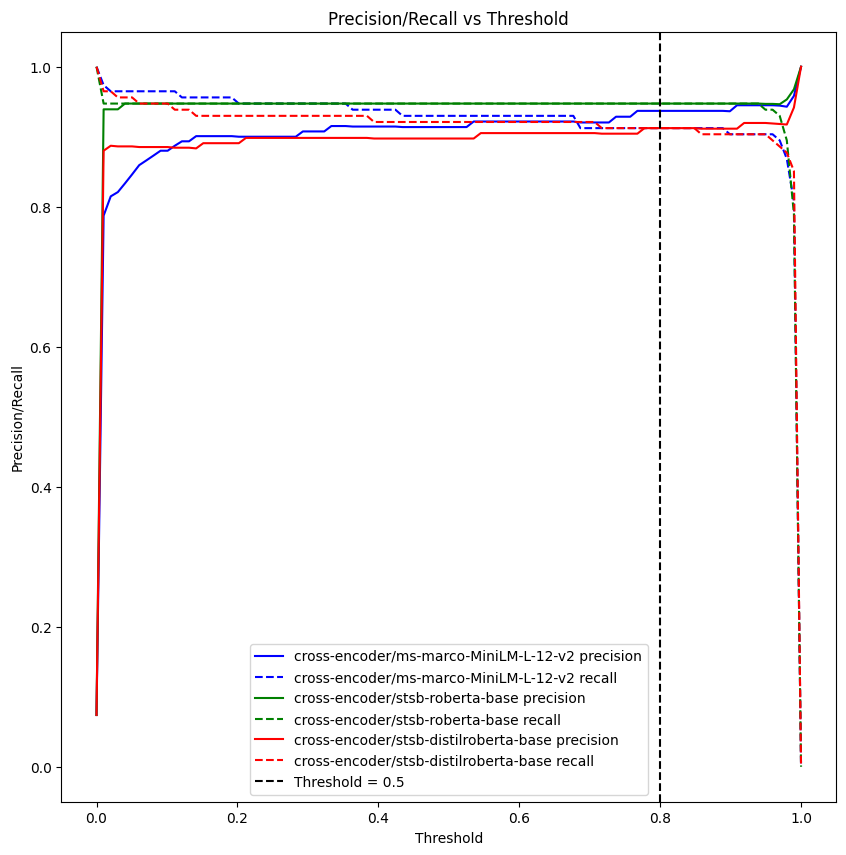

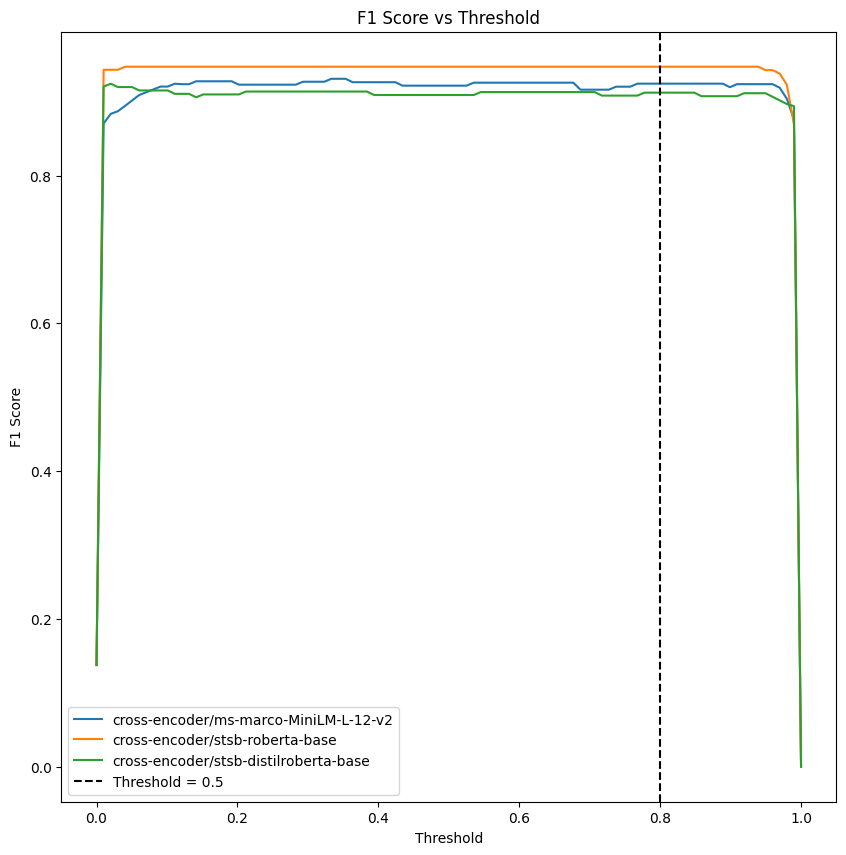

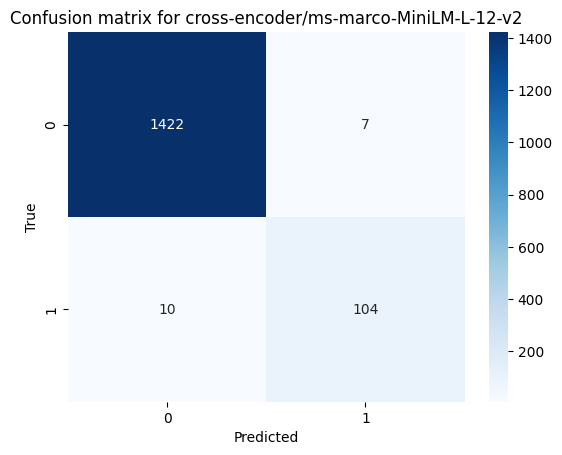

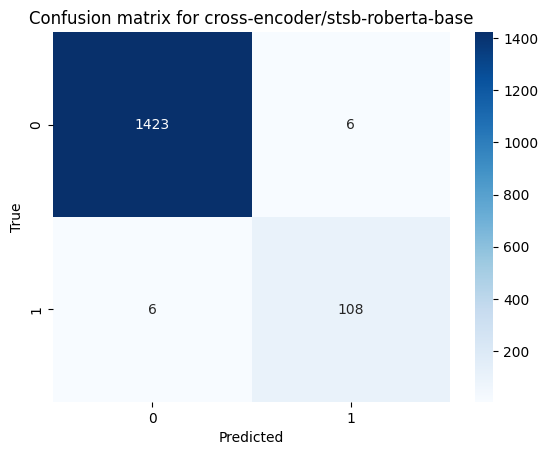

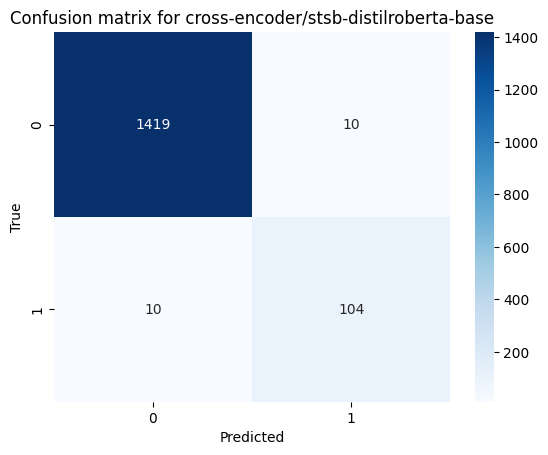

In [28]:
show_results()

In [29]:
%matplotlib inline

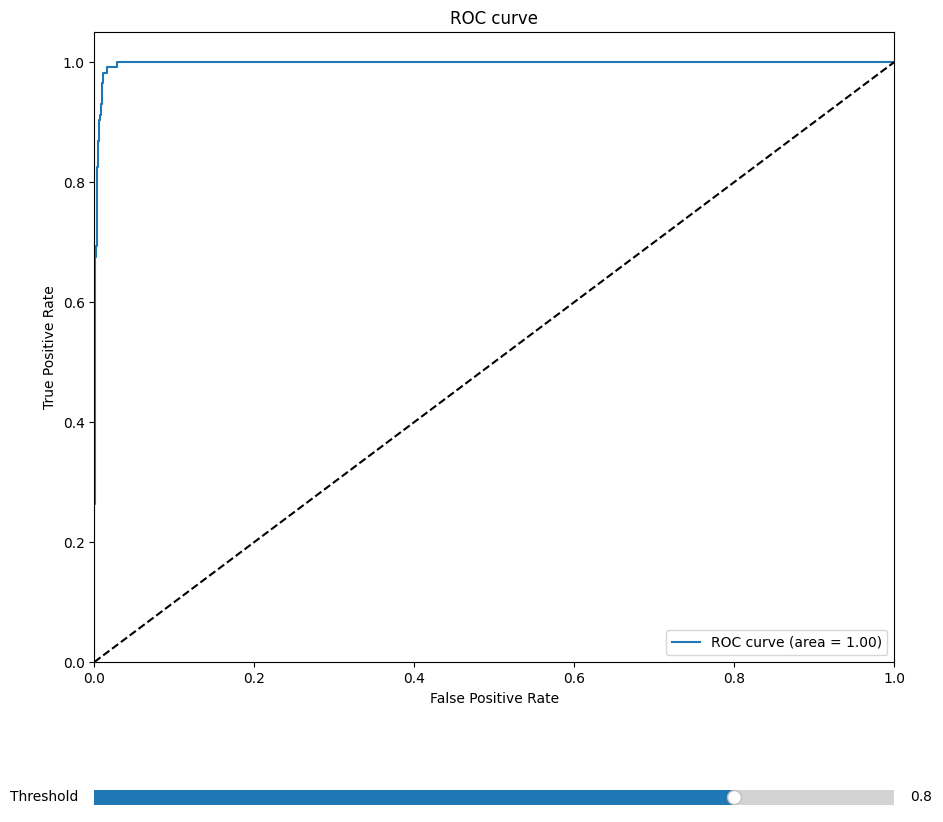

In [30]:
from matplotlib.widgets import Slider

fig, ax = plt.subplots(figsize=(10, 10))
plt.subplots_adjust(left=0.1, bottom=0.25)

fpr, tpr, thresholds = roc_curve(y_test, logits)
roc_auc = roc_auc_score(y_test, logits)
line, = ax.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(loc="lower right")

ax_threshold = plt.axes([0.1, 0.1, 0.8, 0.03], facecolor='lightgoldenrodyellow')
slider_threshold = Slider(ax_threshold, 'Threshold', 0.0, 1.0, valinit=threshold, valstep=0.01)

def update(val):
    threshold = slider_threshold.val
    y_pred = logits > threshold
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    line.set_ydata(tpr)
    line.set_xdata(fpr)
    fig.canvas.draw_idle()

slider_threshold.on_changed(update)

plt.show()